In [1]:
import numpy as np
import pandas as pd
import os
import pathlib
import tensorflow as tf
import seaborn as sn
import matplotlib.pyplot as plt
from tensorflow.keras1.utils import to_categorical, plot_model, image_dataset_from_directory
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, RandomContrast, RandomRotation, RandomZoom, RandomFlip

2023-04-28 08:52:24.082071: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
TF_CPP_MIN_LOG_LEVEL=2

In [3]:
data_dir = pathlib.Path("/home/prostoi/Загрузки/archive/dataset")
data = image_dataset_from_directory(data_dir, seed = 123, image_size=(224, 224))
class_names = data.class_names

Found 4217 files belonging to 4 classes.


2023-04-28 08:52:28.038123: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 08:52:28.040281: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


<Axes: >

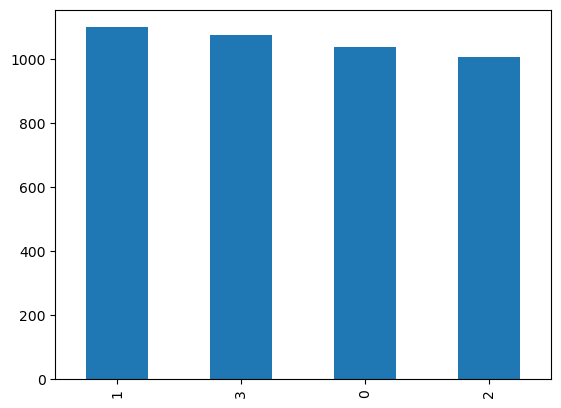

In [4]:
labels = np.concatenate([y for x,y in data], axis=0)
values = pd.value_counts(labels)
values.plot(kind='bar')

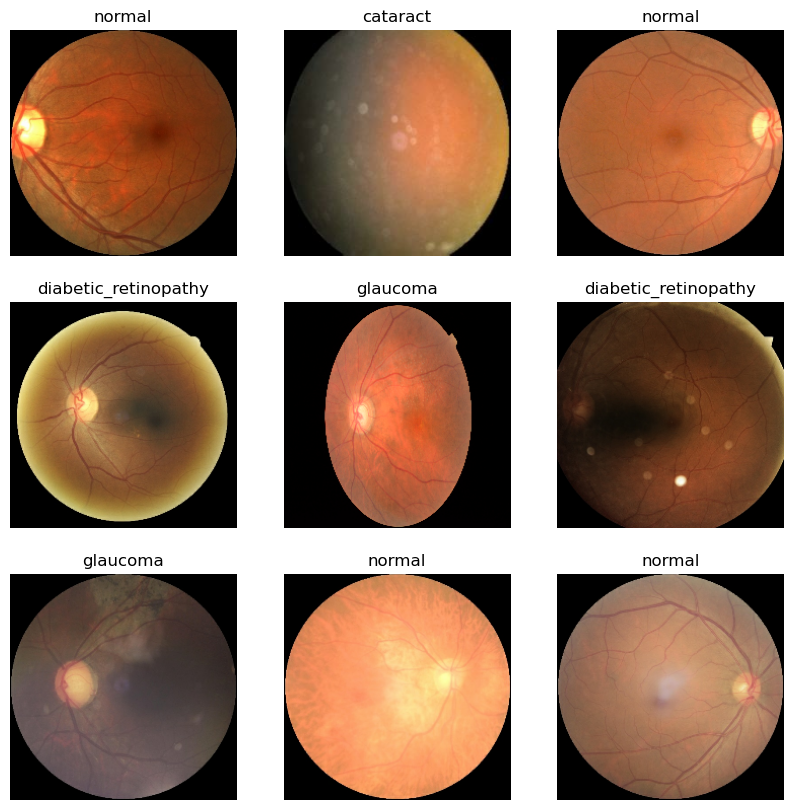

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(data.class_names[labels[i]])
        plt.axis("off")

In [6]:
data = data.map(lambda x, y: (x/255, y))
train_size = int(0.7 * len(data)) +1
val_size = int(0.2 * len(data))
test_size = int(0.1 * len(data))
train = data.take(train_size)
remaining = data.skip(train_size)
val = remaining.take(val_size)
test = remaining.skip(val_size)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [7]:
test_iter = test.as_numpy_iterator()
test_set = {"images":np.empty((0,224,224,3)), "labels":np.empty(0)}
while True:
    try:
        batch = test_iter.next()
        test_set['images'] = np.concatenate((test_set['images'], batch[0]))
        test_set['labels'] = np.concatenate((test_set['labels'], batch[1]))
    except:
        break
y_test = test_set['labels']

In [8]:
def evaluate_model(model):
    model.evaluate(test)
    y_pred = np.argmax(model.predict(test_set['images']), 1)
    print(classification_report(y_test, y_pred, target_names = class_names))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sn.heatmap(cm, annot=True)
    plt.xticks(np.arange(4)+.5, class_names, rotation=90)
    plt.yticks(np.arange(4)+.5, class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

In [9]:
model = Sequential([
        Conv2D(64, (3,3), activation = 'relu',padding='same', input_shape=(224,224,3)),
        Conv2D(64, (3,3), activation = 'relu',padding='same'),
        Conv2D(64, (3,3), activation = 'relu',padding='same'),
        MaxPool2D(),
        Conv2D(128, (3,3), padding='same', activation = 'relu'),
        Conv2D(128, (3,3),padding='same', activation = 'relu'),
        Conv2D(128, (3,3), activation = 'relu',padding='same'),
        MaxPool2D(),
        Flatten(),
        Dense(256, activation = 'relu'),
        Dense(4, activation='softmax')
    ])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 128)     147584    
                                                        

In [11]:
history = model.fit(train, validation_data=val, epochs = 5)

Epoch 1/5
93/93 [==============================] - 1293s 14s/step - loss: 1.0174 - accuracy: 0.5386 - val_loss: 0.8096 - val_accuracy: 0.6322
Epoch 2/5
93/93 [==============================] - 1271s 14s/step - loss: 0.7019 - accuracy: 0.6862 - val_loss: 0.5743 - val_accuracy: 0.7476
Epoch 3/5
93/93 [==============================] - 1277s 14s/step - loss: 0.5588 - accuracy: 0.7544 - val_loss: 0.6176 - val_accuracy: 0.7356
Epoch 4/5
93/93 [==============================] - 1283s 14s/step - loss: 0.5028 - accuracy: 0.7866 - val_loss: 0.5885 - val_accuracy: 0.7632
Epoch 5/5
93/93 [==============================] - 1326s 14s/step - loss: 0.4748 - accuracy: 0.7977 - val_loss: 0.4946 - val_accuracy: 0.8041


In [12]:
def plot_performance(epochs, history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

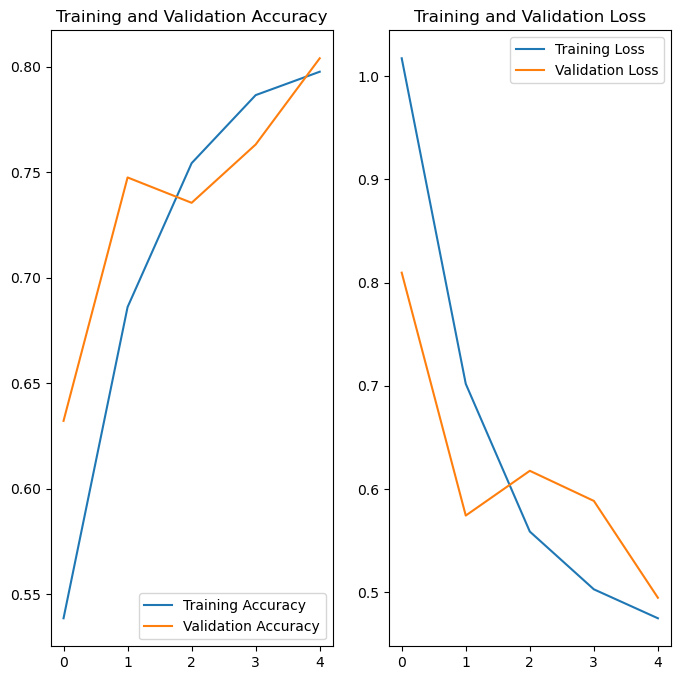

In [13]:
plot_performance(5, history)

In [2]:
import numpy as np
import pandas as pd
import os
import pathlib
import tensorflow as tf
import seaborn as sn
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical, plot_model, image_dataset_from_directory
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, RandomContrast, RandomRotation, RandomZoom, RandomFlip
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random

2023-04-30 12:56:03.072695: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/prostoi/anaconda3/envs/inf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
TF_CPP_MIN_LOG_LEVEL=2

In [4]:
data_dir = pathlib.Path("/home/prostoi/Загрузки/archive/dataset")
data = image_dataset_from_directory(data_dir, seed = 123, image_size=(224, 224))
class_names = data.class_names

Found 4217 files belonging to 4 classes.


2023-04-30 12:56:06.522764: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-30 12:56:06.523237: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
data = data.map(lambda x, y: (x/255, y))
train_size = int(0.7 * len(data)) +1
val_size = int(0.2 * len(data))
test_size = int(0.1 * len(data))
train = data.take(train_size)
remaining = data.skip(train_size)
val = remaining.take(val_size)
test = remaining.skip(val_size)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [6]:
test_iter = test.as_numpy_iterator()
test_set = {"images":np.empty((0,224,224,3)), "labels":np.empty(0)}
while True:
    try:
        batch = test_iter.next()
        test_set['images'] = np.concatenate((test_set['images'], batch[0]))
        test_set['labels'] = np.concatenate((test_set['labels'], batch[1]))
    except:
        break
y_test = test_set['labels']

In [7]:
def evaluate_model(model):
    model.evaluate(test)
    y_pred = np.argmax(model.predict(test_set['images']), 1)
    print(classification_report(y_test, y_pred, target_names = class_names))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sn.heatmap(cm, annot=True)
    plt.xticks(np.arange(4)+.5, class_names, rotation=90)
    plt.yticks(np.arange(4)+.5, class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

In [8]:
model = Sequential([
        Conv2D(64, (3,3), activation = 'relu',padding='same', input_shape=(224,224,3)),
        Conv2D(64, (3,3), activation = 'relu',padding='same'),
        Conv2D(64, (3,3), activation = 'relu',padding='same'),
        MaxPool2D(),
        Conv2D(128, (3,3), padding='same', activation = 'relu'),
        Conv2D(128, (3,3),padding='same', activation = 'relu'),
        Conv2D(128, (3,3), activation = 'relu',padding='same'),
        MaxPool2D(),
        Flatten(),
        Dense(256, activation = 'relu'),
        Dense(4, activation='softmax')
    ])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
history = model.fit(train, validation_data=val, epochs = 3)

Epoch 1/3
93/93 [==============================] - 1763s 19s/step - loss: 0.7017 - accuracy: 0.6993 - val_loss: 0.6731 - val_accuracy: 0.7091
Epoch 2/3
93/93 [==============================] - 1358s 15s/step - loss: 0.5955 - accuracy: 0.7476 - val_loss: 0.5772 - val_accuracy: 0.7764
Epoch 3/3
93/93 [==============================] - 1299s 14s/step - loss: 0.5597 - accuracy: 0.7668 - val_loss: 0.5092 - val_accuracy: 0.7885


13/13 [==============================] - 23s 2s/step
                      precision    recall  f1-score   support

            cataract       0.74      0.67      0.70        97
diabetic_retinopathy       0.98      0.97      0.98       103
            glaucoma       0.74      0.58      0.65       104
              normal       0.72      0.95      0.82       105

            accuracy                           0.79       409
           macro avg       0.80      0.79      0.79       409
        weighted avg       0.80      0.79      0.79       409



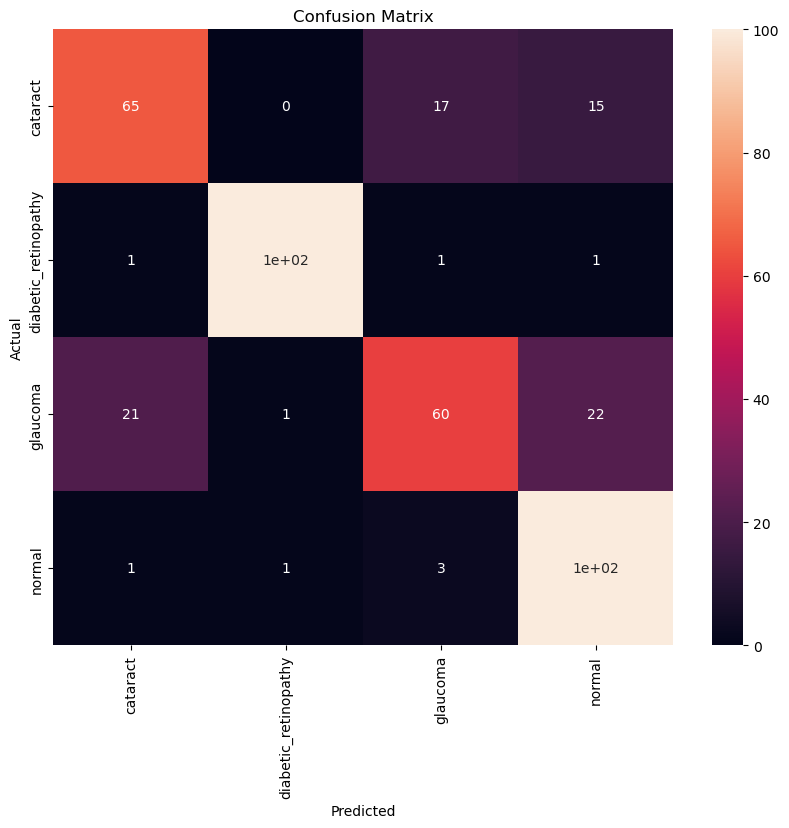

In [16]:
evaluate_model(model)

In [17]:
from tensorflow.keras.preprocessing import image
from skimage.io import imread
from skimage.transform import resize

def predict_image(image_path):
    img = imread(image_path)
    img = resize(img, (224,224))

    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    preds = model.predict(img)
    prediction = np.argmax(preds)
    pct = np.max(preds)
    if prediction == 0:
        print('Cataract')
    elif prediction == 1:
        print('Diabetic retinopathy')
    elif prediction == 2:
        print('Glaucoma')
    else:
        print('Normal')
    print(pct)
    return img

In [18]:
def explain_prediction(image_path):
    img = predict_image(image_path)
    explainer = lime_image.LimeImageExplainer(random_state=12)
    explanation = explainer.explain_instance(
             img[0].astype('double'), 
             model.predict
    )
    from skimage.segmentation import mark_boundaries

    temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
    temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
    ax1.imshow(mark_boundaries(temp_1, mask_1))
    ax2.imshow(mark_boundaries(temp_2, mask_2))
    ax1.axis('off')
    ax2.axis('off')

1/1 [==============================] - 0s 84ms/step
Diabetic retinopathy
0.999949


  0%|                                                  | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 487ms/step


  1%|▍                                        | 10/1000 [00:00<00:53, 18.35it/s]

1/1 [==============================] - 1s 537ms/step


  2%|▊                                        | 20/1000 [00:01<00:56, 17.29it/s]

1/1 [==============================] - 0s 487ms/step


  3%|█▏                                       | 30/1000 [00:01<00:55, 17.59it/s]

1/1 [==============================] - 1s 525ms/step


  4%|█▋                                       | 40/1000 [00:02<00:56, 17.13it/s]

1/1 [==============================] - 1s 552ms/step


  5%|██                                       | 50/1000 [00:02<00:57, 16.55it/s]

1/1 [==============================] - 0s 495ms/step


  6%|██▍                                      | 60/1000 [00:03<00:55, 16.83it/s]

1/1 [==============================] - 1s 538ms/step


  7%|██▊                                      | 70/1000 [00:04<00:55, 16.67it/s]

1/1 [==============================] - 1s 535ms/step


  8%|███▎                                     | 80/1000 [00:04<00:54, 16.73it/s]

1/1 [==============================] - 1s 552ms/step


  9%|███▋                                     | 90/1000 [00:05<00:54, 16.58it/s]

1/1 [==============================] - 1s 534ms/step


 10%|████                                    | 100/1000 [00:05<00:54, 16.64it/s]

1/1 [==============================] - 0s 488ms/step


 11%|████▍                                   | 110/1000 [00:06<00:52, 17.07it/s]

1/1 [==============================] - 1s 557ms/step


 12%|████▊                                   | 120/1000 [00:07<00:52, 16.77it/s]

1/1 [==============================] - 0s 497ms/step


 13%|█████▏                                  | 130/1000 [00:07<00:50, 17.11it/s]

1/1 [==============================] - 0s 495ms/step


 14%|█████▌                                  | 140/1000 [00:08<00:49, 17.43it/s]

1/1 [==============================] - 1s 544ms/step


 15%|██████                                  | 150/1000 [00:08<00:49, 17.19it/s]

1/1 [==============================] - 0s 493ms/step


 16%|██████▍                                 | 160/1000 [00:09<00:48, 17.49it/s]

1/1 [==============================] - 1s 549ms/step


 17%|██████▊                                 | 170/1000 [00:09<00:48, 17.21it/s]

1/1 [==============================] - 1s 566ms/step


 18%|███████▏                                | 180/1000 [00:10<00:49, 16.68it/s]

1/1 [==============================] - 1s 646ms/step


 19%|███████▌                                | 190/1000 [00:11<00:52, 15.52it/s]

1/1 [==============================] - 1s 620ms/step


 20%|████████                                | 200/1000 [00:12<00:52, 15.13it/s]

1/1 [==============================] - 1s 597ms/step


 21%|████████▍                               | 210/1000 [00:12<00:53, 14.90it/s]

1/1 [==============================] - 1s 595ms/step


 22%|████████▊                               | 220/1000 [00:13<00:52, 14.81it/s]

1/1 [==============================] - 1s 659ms/step


 23%|█████████▏                              | 230/1000 [00:14<00:53, 14.40it/s]

1/1 [==============================] - 1s 641ms/step


 24%|█████████▌                              | 240/1000 [00:14<00:53, 14.29it/s]

1/1 [==============================] - 1s 727ms/step


 25%|██████████                              | 250/1000 [00:15<00:54, 13.73it/s]

1/1 [==============================] - 1s 679ms/step


 26%|██████████▍                             | 260/1000 [00:16<00:54, 13.64it/s]

1/1 [==============================] - 1s 606ms/step


 27%|██████████▊                             | 270/1000 [00:17<00:52, 13.86it/s]

1/1 [==============================] - 1s 612ms/step


 28%|███████████▏                            | 280/1000 [00:17<00:51, 13.95it/s]

1/1 [==============================] - 1s 625ms/step


 29%|███████████▌                            | 290/1000 [00:18<00:50, 13.93it/s]

1/1 [==============================] - 1s 604ms/step


 30%|████████████                            | 300/1000 [00:19<00:49, 14.21it/s]

1/1 [==============================] - 1s 731ms/step


 31%|████████████▍                           | 310/1000 [00:20<00:50, 13.66it/s]

1/1 [==============================] - 1s 706ms/step


 32%|████████████▊                           | 320/1000 [00:20<00:50, 13.41it/s]

1/1 [==============================] - 1s 739ms/step


 33%|█████████████▏                          | 330/1000 [00:21<00:51, 13.01it/s]

1/1 [==============================] - 1s 855ms/step


 34%|█████████████▌                          | 340/1000 [00:22<00:54, 12.19it/s]

1/1 [==============================] - 1s 694ms/step


 35%|██████████████                          | 350/1000 [00:23<00:52, 12.40it/s]

1/1 [==============================] - 1s 654ms/step


 36%|██████████████▍                         | 360/1000 [00:24<00:51, 12.52it/s]

1/1 [==============================] - 1s 659ms/step


 37%|██████████████▊                         | 370/1000 [00:24<00:48, 12.88it/s]

1/1 [==============================] - 1s 725ms/step


 38%|███████████████▏                        | 380/1000 [00:25<00:48, 12.78it/s]

1/1 [==============================] - 1s 681ms/step


 39%|███████████████▌                        | 390/1000 [00:26<00:47, 12.98it/s]

1/1 [==============================] - 1s 584ms/step


 40%|████████████████                        | 400/1000 [00:27<00:44, 13.50it/s]

1/1 [==============================] - 1s 618ms/step


 41%|████████████████▍                       | 410/1000 [00:27<00:42, 13.81it/s]

1/1 [==============================] - 1s 589ms/step


 42%|████████████████▊                       | 420/1000 [00:28<00:40, 14.23it/s]

1/1 [==============================] - 1s 573ms/step


 43%|█████████████████▏                      | 430/1000 [00:29<00:38, 14.64it/s]

1/1 [==============================] - 1s 622ms/step


 44%|█████████████████▌                      | 440/1000 [00:29<00:38, 14.52it/s]

1/1 [==============================] - 1s 605ms/step


 45%|██████████████████                      | 450/1000 [00:30<00:38, 14.46it/s]

1/1 [==============================] - 1s 673ms/step


 46%|██████████████████▍                     | 460/1000 [00:31<00:38, 14.10it/s]

1/1 [==============================] - 1s 720ms/step


 47%|██████████████████▊                     | 470/1000 [00:31<00:38, 13.64it/s]

1/1 [==============================] - 1s 734ms/step


 48%|███████████████████▏                    | 480/1000 [00:32<00:39, 13.14it/s]

1/1 [==============================] - 1s 731ms/step


 49%|███████████████████▌                    | 490/1000 [00:33<00:39, 12.77it/s]

1/1 [==============================] - 1s 752ms/step


 50%|████████████████████                    | 500/1000 [00:34<00:40, 12.46it/s]

1/1 [==============================] - 1s 881ms/step


 51%|████████████████████▍                   | 510/1000 [00:35<00:41, 11.81it/s]

1/1 [==============================] - 1s 637ms/step


 52%|████████████████████▊                   | 520/1000 [00:36<00:39, 12.14it/s]

1/1 [==============================] - 1s 586ms/step


 53%|█████████████████████▏                  | 530/1000 [00:36<00:36, 12.97it/s]

1/1 [==============================] - 1s 661ms/step


 54%|█████████████████████▌                  | 540/1000 [00:37<00:34, 13.16it/s]

1/1 [==============================] - 1s 584ms/step


 55%|██████████████████████                  | 550/1000 [00:38<00:32, 13.68it/s]

1/1 [==============================] - 1s 602ms/step


 56%|██████████████████████▍                 | 560/1000 [00:38<00:31, 14.09it/s]

1/1 [==============================] - 1s 542ms/step


 57%|██████████████████████▊                 | 570/1000 [00:39<00:29, 14.72it/s]

1/1 [==============================] - 1s 654ms/step


 58%|███████████████████████▏                | 580/1000 [00:40<00:29, 14.43it/s]

1/1 [==============================] - 1s 607ms/step


 59%|███████████████████████▌                | 590/1000 [00:40<00:28, 14.40it/s]

1/1 [==============================] - 1s 651ms/step


 60%|████████████████████████                | 600/1000 [00:41<00:28, 14.20it/s]

1/1 [==============================] - 1s 630ms/step


 61%|████████████████████████▍               | 610/1000 [00:42<00:27, 14.06it/s]

1/1 [==============================] - 1s 587ms/step


 62%|████████████████████████▊               | 620/1000 [00:43<00:26, 14.39it/s]

1/1 [==============================] - 1s 622ms/step


 63%|█████████████████████████▏              | 630/1000 [00:43<00:25, 14.38it/s]

1/1 [==============================] - 1s 635ms/step


 64%|█████████████████████████▌              | 640/1000 [00:44<00:25, 14.25it/s]

1/1 [==============================] - 1s 582ms/step


 65%|██████████████████████████              | 650/1000 [00:45<00:24, 14.58it/s]

1/1 [==============================] - 1s 620ms/step


 66%|██████████████████████████▍             | 660/1000 [00:45<00:23, 14.58it/s]

1/1 [==============================] - 1s 570ms/step


 67%|██████████████████████████▊             | 670/1000 [00:46<00:22, 14.84it/s]

1/1 [==============================] - 1s 609ms/step


 68%|███████████████████████████▏            | 680/1000 [00:47<00:21, 14.85it/s]

1/1 [==============================] - 1s 570ms/step


 69%|███████████████████████████▌            | 690/1000 [00:47<00:20, 15.00it/s]

1/1 [==============================] - 1s 559ms/step


 70%|████████████████████████████            | 700/1000 [00:48<00:19, 15.20it/s]

1/1 [==============================] - 1s 563ms/step


 71%|████████████████████████████▍           | 710/1000 [00:49<00:18, 15.30it/s]

1/1 [==============================] - 1s 583ms/step


 72%|████████████████████████████▊           | 720/1000 [00:49<00:18, 15.31it/s]

1/1 [==============================] - 1s 616ms/step


 73%|█████████████████████████████▏          | 730/1000 [00:50<00:17, 15.00it/s]

1/1 [==============================] - 1s 641ms/step


 74%|█████████████████████████████▌          | 740/1000 [00:51<00:17, 14.69it/s]

1/1 [==============================] - 1s 621ms/step


 75%|██████████████████████████████          | 750/1000 [00:51<00:17, 14.44it/s]

1/1 [==============================] - 1s 645ms/step


 76%|██████████████████████████████▍         | 760/1000 [00:52<00:16, 14.16it/s]

1/1 [==============================] - 1s 599ms/step


 77%|██████████████████████████████▊         | 770/1000 [00:53<00:15, 14.40it/s]

1/1 [==============================] - 1s 627ms/step


 78%|███████████████████████████████▏        | 780/1000 [00:53<00:15, 14.26it/s]

1/1 [==============================] - 1s 589ms/step


 79%|███████████████████████████████▌        | 790/1000 [00:54<00:14, 14.34it/s]

1/1 [==============================] - 1s 617ms/step


 80%|████████████████████████████████        | 800/1000 [00:55<00:13, 14.34it/s]

1/1 [==============================] - 1s 608ms/step


 81%|████████████████████████████████▍       | 810/1000 [00:56<00:13, 14.40it/s]

1/1 [==============================] - 1s 609ms/step


 82%|████████████████████████████████▊       | 820/1000 [00:56<00:12, 14.41it/s]

1/1 [==============================] - 1s 619ms/step


 83%|█████████████████████████████████▏      | 830/1000 [00:57<00:11, 14.39it/s]

1/1 [==============================] - 1s 568ms/step


 84%|█████████████████████████████████▌      | 840/1000 [00:58<00:10, 14.76it/s]

1/1 [==============================] - 1s 606ms/step


 85%|██████████████████████████████████      | 850/1000 [00:58<00:10, 14.77it/s]

1/1 [==============================] - 1s 578ms/step


 86%|██████████████████████████████████▍     | 860/1000 [00:59<00:09, 14.94it/s]

1/1 [==============================] - 1s 602ms/step


 87%|██████████████████████████████████▊     | 870/1000 [01:00<00:08, 14.96it/s]

1/1 [==============================] - 1s 537ms/step


 88%|███████████████████████████████████▏    | 880/1000 [01:00<00:07, 15.37it/s]

1/1 [==============================] - 1s 588ms/step


 89%|███████████████████████████████████▌    | 890/1000 [01:01<00:07, 15.32it/s]

1/1 [==============================] - 1s 599ms/step


 90%|████████████████████████████████████    | 900/1000 [01:01<00:06, 15.17it/s]

1/1 [==============================] - 1s 535ms/step


 91%|████████████████████████████████████▍   | 910/1000 [01:02<00:05, 15.66it/s]

1/1 [==============================] - 1s 586ms/step


 92%|████████████████████████████████████▊   | 920/1000 [01:03<00:05, 15.60it/s]

1/1 [==============================] - 1s 636ms/step


 93%|█████████████████████████████████████▏  | 930/1000 [01:03<00:04, 15.07it/s]

1/1 [==============================] - 1s 611ms/step


 94%|█████████████████████████████████████▌  | 940/1000 [01:04<00:04, 14.91it/s]

1/1 [==============================] - 1s 646ms/step


 95%|██████████████████████████████████████  | 950/1000 [01:05<00:03, 14.63it/s]

1/1 [==============================] - 1s 596ms/step


 96%|██████████████████████████████████████▍ | 960/1000 [01:06<00:02, 14.72it/s]

1/1 [==============================] - 1s 641ms/step


 97%|██████████████████████████████████████▊ | 970/1000 [01:06<00:02, 14.54it/s]

1/1 [==============================] - 1s 585ms/step


 98%|███████████████████████████████████████▏| 980/1000 [01:07<00:01, 14.62it/s]

1/1 [==============================] - 1s 620ms/step


 99%|███████████████████████████████████████▌| 990/1000 [01:08<00:00, 14.40it/s]

1/1 [==============================] - 1s 585ms/step


100%|███████████████████████████████████████| 1000/1000 [01:08<00:00, 14.54it/s]


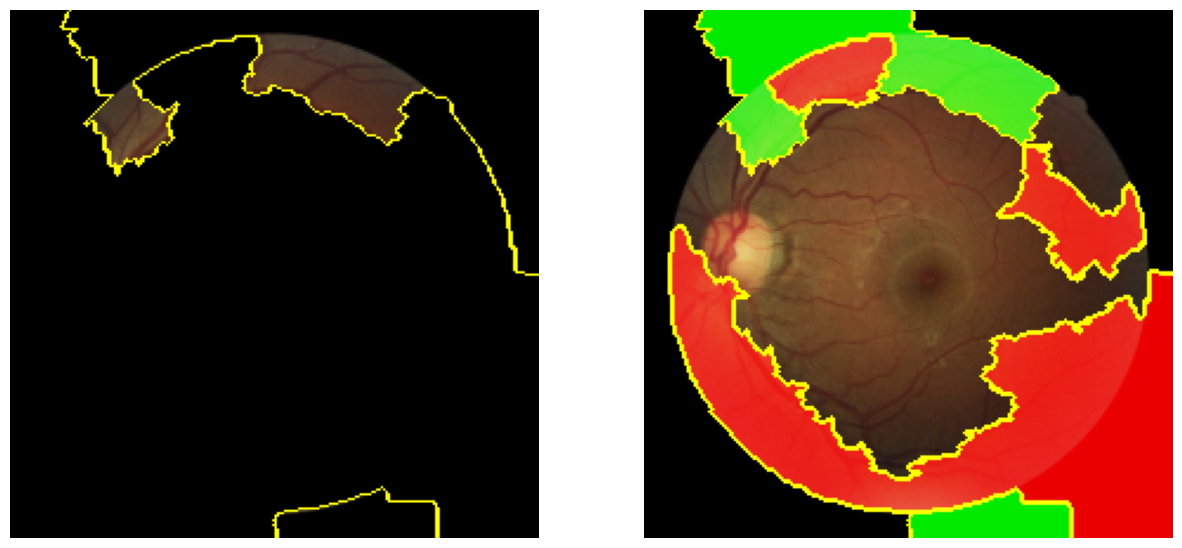

In [19]:
explain_prediction("/home/prostoi/Загрузки/archive/dataset/diabetic_retinopathy/1196_left.jpeg")

1/1 [==============================] - 0s 195ms/step
Glaucoma
0.8331872


  0%|                                                  | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 568ms/step


  1%|▍                                        | 10/1000 [00:00<01:02, 15.94it/s]

1/1 [==============================] - 1s 572ms/step


  2%|▊                                        | 20/1000 [00:01<01:04, 15.27it/s]

1/1 [==============================] - 1s 589ms/step


  3%|█▏                                       | 30/1000 [00:01<01:04, 15.04it/s]

1/1 [==============================] - 1s 550ms/step


  4%|█▋                                       | 40/1000 [00:02<01:02, 15.46it/s]

1/1 [==============================] - 0s 482ms/step


  5%|██                                       | 50/1000 [00:03<00:57, 16.45it/s]

1/1 [==============================] - 1s 553ms/step


  6%|██▍                                      | 60/1000 [00:03<00:57, 16.42it/s]

1/1 [==============================] - 1s 538ms/step


  7%|██▊                                      | 70/1000 [00:04<00:56, 16.46it/s]

1/1 [==============================] - 0s 481ms/step


  8%|███▎                                     | 80/1000 [00:04<00:54, 16.78it/s]

1/1 [==============================] - 1s 550ms/step


  9%|███▋                                     | 90/1000 [00:05<00:54, 16.56it/s]

1/1 [==============================] - 1s 767ms/step


 10%|████                                    | 100/1000 [00:06<01:02, 14.51it/s]

1/1 [==============================] - 1s 638ms/step


 11%|████▍                                   | 110/1000 [00:07<01:06, 13.40it/s]

1/1 [==============================] - 1s 687ms/step


 12%|████▊                                   | 120/1000 [00:08<01:06, 13.21it/s]

1/1 [==============================] - 1s 866ms/step


 13%|█████▏                                  | 130/1000 [00:09<01:19, 10.98it/s]

1/1 [==============================] - 1s 945ms/step


 14%|█████▌                                  | 140/1000 [00:10<01:24, 10.13it/s]

1/1 [==============================] - 1s 855ms/step


 15%|██████                                  | 150/1000 [00:11<01:26,  9.77it/s]

1/1 [==============================] - 1s 1s/step


 16%|██████▍                                 | 160/1000 [00:13<01:43,  8.08it/s]

1/1 [==============================] - 1s 950ms/step


 17%|██████▊                                 | 170/1000 [00:14<01:43,  8.04it/s]

1/1 [==============================] - 1s 796ms/step


 18%|███████▏                                | 180/1000 [00:16<01:47,  7.62it/s]

1/1 [==============================] - 1s 1s/step


 19%|███████▌                                | 190/1000 [00:17<01:54,  7.09it/s]

1/1 [==============================] - 3s 3s/step


 20%|████████                                | 200/1000 [00:25<04:32,  2.93it/s]

1/1 [==============================] - 4s 4s/step


 21%|████████▍                               | 210/1000 [00:32<05:53,  2.24it/s]

1/1 [==============================] - 3s 3s/step


 22%|████████▊                               | 220/1000 [00:39<06:39,  1.95it/s]

1/1 [==============================] - 1s 768ms/step


 23%|█████████▏                              | 230/1000 [00:41<05:15,  2.44it/s]

1/1 [==============================] - 1s 741ms/step


 24%|█████████▌                              | 240/1000 [00:42<04:00,  3.16it/s]

1/1 [==============================] - 1s 688ms/step


 25%|██████████                              | 250/1000 [00:42<03:04,  4.07it/s]

1/1 [==============================] - 1s 637ms/step


 26%|██████████▍                             | 260/1000 [00:43<02:22,  5.18it/s]

1/1 [==============================] - 1s 610ms/step


 27%|██████████▊                             | 270/1000 [00:44<01:53,  6.43it/s]

1/1 [==============================] - 1s 580ms/step


 28%|███████████▏                            | 280/1000 [00:44<01:32,  7.79it/s]

1/1 [==============================] - 1s 625ms/step


 29%|███████████▌                            | 290/1000 [00:45<01:18,  9.07it/s]

1/1 [==============================] - 1s 733ms/step


 30%|████████████                            | 300/1000 [00:46<01:10,  9.87it/s]

1/1 [==============================] - 1s 746ms/step


 31%|████████████▍                           | 310/1000 [00:47<01:05, 10.49it/s]

1/1 [==============================] - 1s 594ms/step


 32%|████████████▊                           | 320/1000 [00:47<00:59, 11.50it/s]

1/1 [==============================] - 1s 926ms/step


 33%|█████████████▏                          | 330/1000 [00:48<01:01, 10.94it/s]

1/1 [==============================] - 1s 868ms/step


 34%|█████████████▌                          | 340/1000 [00:50<01:12,  9.08it/s]

1/1 [==============================] - 1s 665ms/step


 35%|██████████████                          | 350/1000 [00:51<01:06,  9.73it/s]

1/1 [==============================] - 1s 778ms/step


 36%|██████████████▍                         | 360/1000 [00:52<01:05,  9.82it/s]

1/1 [==============================] - 1s 733ms/step


 37%|██████████████▊                         | 370/1000 [00:53<01:01, 10.18it/s]

1/1 [==============================] - 1s 842ms/step


 38%|███████████████▏                        | 380/1000 [00:54<01:04,  9.67it/s]

1/1 [==============================] - 1s 1s/step


 39%|███████████████▌                        | 390/1000 [00:58<01:59,  5.12it/s]

1/1 [==============================] - 1s 690ms/step


 40%|████████████████                        | 400/1000 [01:00<01:55,  5.19it/s]

1/1 [==============================] - 1s 1s/step


 41%|████████████████▍                       | 410/1000 [01:01<01:43,  5.69it/s]

1/1 [==============================] - 1s 848ms/step


 42%|████████████████▊                       | 420/1000 [01:02<01:29,  6.46it/s]

1/1 [==============================] - 2s 2s/step


 43%|█████████████████▏                      | 430/1000 [01:04<01:33,  6.08it/s]

1/1 [==============================] - 3s 3s/step


 44%|█████████████████▌                      | 440/1000 [01:07<01:53,  4.94it/s]

1/1 [==============================] - 1s 1s/step


 45%|██████████████████                      | 450/1000 [01:09<01:45,  5.21it/s]

1/1 [==============================] - 1s 746ms/step


 46%|██████████████████▍                     | 460/1000 [01:10<01:35,  5.64it/s]

1/1 [==============================] - 1s 1s/step


 47%|██████████████████▊                     | 470/1000 [01:11<01:26,  6.10it/s]

1/1 [==============================] - 1s 1s/step


 48%|███████████████████▏                    | 480/1000 [01:13<01:24,  6.18it/s]

1/1 [==============================] - 2s 2s/step


 49%|███████████████████▌                    | 490/1000 [01:16<01:41,  5.00it/s]

1/1 [==============================] - 1s 1s/step


 50%|████████████████████                    | 500/1000 [01:18<01:34,  5.31it/s]

1/1 [==============================] - 1s 1s/step


 51%|████████████████████▍                   | 510/1000 [01:19<01:28,  5.51it/s]

1/1 [==============================] - 1s 1s/step


 52%|████████████████████▊                   | 520/1000 [01:21<01:28,  5.40it/s]

1/1 [==============================] - 1s 829ms/step


 53%|█████████████████████▏                  | 530/1000 [01:23<01:26,  5.42it/s]

1/1 [==============================] - 1s 1s/step


 54%|█████████████████████▌                  | 540/1000 [01:25<01:22,  5.60it/s]

1/1 [==============================] - 1s 1s/step


 55%|██████████████████████                  | 550/1000 [01:26<01:15,  5.99it/s]

1/1 [==============================] - 1s 903ms/step


 56%|██████████████████████▍                 | 560/1000 [01:27<01:08,  6.46it/s]

1/1 [==============================] - 1s 906ms/step


 57%|██████████████████████▊                 | 570/1000 [01:29<01:10,  6.13it/s]

1/1 [==============================] - 1s 1s/step


 58%|███████████████████████▏                | 580/1000 [01:30<01:05,  6.45it/s]

1/1 [==============================] - 1s 808ms/step


 59%|███████████████████████▌                | 590/1000 [01:32<01:02,  6.59it/s]

1/1 [==============================] - 1s 1s/step


 60%|████████████████████████                | 600/1000 [01:33<00:58,  6.88it/s]

1/1 [==============================] - 1s 1s/step


 61%|████████████████████████▍               | 610/1000 [01:34<00:55,  7.08it/s]

1/1 [==============================] - 1s 1s/step


 62%|████████████████████████▊               | 620/1000 [01:36<00:59,  6.34it/s]

1/1 [==============================] - 1s 636ms/step


 63%|█████████████████████████▏              | 630/1000 [01:37<00:50,  7.32it/s]

1/1 [==============================] - 1s 765ms/step


 64%|█████████████████████████▌              | 640/1000 [01:38<00:44,  8.08it/s]

1/1 [==============================] - 1s 807ms/step


 65%|██████████████████████████              | 650/1000 [01:39<00:42,  8.33it/s]

1/1 [==============================] - 1s 756ms/step


 66%|██████████████████████████▍             | 660/1000 [01:40<00:38,  8.87it/s]

1/1 [==============================] - 1s 816ms/step


 67%|██████████████████████████▊             | 670/1000 [01:41<00:36,  9.11it/s]

1/1 [==============================] - 1s 834ms/step


 68%|███████████████████████████▏            | 680/1000 [01:42<00:34,  9.17it/s]

1/1 [==============================] - 1s 785ms/step


 69%|███████████████████████████▌            | 690/1000 [01:43<00:33,  9.31it/s]

1/1 [==============================] - 1s 984ms/step


 70%|████████████████████████████            | 700/1000 [01:45<00:32,  9.14it/s]

1/1 [==============================] - 1s 697ms/step


 71%|████████████████████████████▍           | 710/1000 [01:45<00:29,  9.84it/s]

1/1 [==============================] - 1s 684ms/step


 72%|████████████████████████████▊           | 720/1000 [01:46<00:26, 10.63it/s]

1/1 [==============================] - 1s 662ms/step


 73%|█████████████████████████████▏          | 730/1000 [01:47<00:23, 11.36it/s]

1/1 [==============================] - 1s 695ms/step


 74%|█████████████████████████████▌          | 740/1000 [01:48<00:22, 11.78it/s]

1/1 [==============================] - 1s 614ms/step


 75%|██████████████████████████████          | 750/1000 [01:48<00:20, 12.40it/s]

1/1 [==============================] - 1s 652ms/step


 76%|██████████████████████████████▍         | 760/1000 [01:49<00:18, 12.79it/s]

1/1 [==============================] - 1s 653ms/step


 77%|██████████████████████████████▊         | 770/1000 [01:50<00:17, 12.97it/s]

1/1 [==============================] - 1s 756ms/step


 78%|███████████████████████████████▏        | 780/1000 [01:51<00:17, 12.61it/s]

1/1 [==============================] - 1s 710ms/step


 79%|███████████████████████████████▌        | 790/1000 [01:52<00:16, 12.63it/s]

1/1 [==============================] - 1s 658ms/step


 80%|████████████████████████████████        | 800/1000 [01:52<00:15, 12.81it/s]

1/1 [==============================] - 1s 560ms/step


 81%|████████████████████████████████▍       | 810/1000 [01:53<00:13, 13.57it/s]

1/1 [==============================] - 1s 540ms/step


 82%|████████████████████████████████▊       | 820/1000 [01:54<00:12, 14.31it/s]

1/1 [==============================] - 1s 583ms/step


 83%|█████████████████████████████████▏      | 830/1000 [01:54<00:11, 14.60it/s]

1/1 [==============================] - 1s 604ms/step


 84%|█████████████████████████████████▌      | 840/1000 [01:55<00:10, 14.68it/s]

1/1 [==============================] - 1s 539ms/step


 85%|██████████████████████████████████      | 850/1000 [01:56<00:10, 14.98it/s]

1/1 [==============================] - 1s 599ms/step


 86%|██████████████████████████████████▍     | 860/1000 [01:56<00:09, 14.85it/s]

1/1 [==============================] - 1s 611ms/step


 87%|██████████████████████████████████▊     | 870/1000 [01:57<00:08, 14.76it/s]

1/1 [==============================] - 1s 654ms/step


 88%|███████████████████████████████████▏    | 880/1000 [01:58<00:08, 14.39it/s]

1/1 [==============================] - 1s 651ms/step


 89%|███████████████████████████████████▌    | 890/1000 [01:58<00:07, 14.15it/s]

1/1 [==============================] - 1s 666ms/step


 90%|████████████████████████████████████    | 900/1000 [01:59<00:07, 13.97it/s]

1/1 [==============================] - 1s 597ms/step


 91%|████████████████████████████████████▍   | 910/1000 [02:00<00:06, 14.27it/s]

1/1 [==============================] - 1s 645ms/step


 92%|████████████████████████████████████▊   | 920/1000 [02:00<00:05, 14.23it/s]

1/1 [==============================] - 1s 640ms/step


 93%|█████████████████████████████████████▏  | 930/1000 [02:01<00:04, 14.15it/s]

1/1 [==============================] - 1s 585ms/step


 94%|█████████████████████████████████████▌  | 940/1000 [02:02<00:04, 14.41it/s]

1/1 [==============================] - 1s 616ms/step


 95%|██████████████████████████████████████  | 950/1000 [02:03<00:03, 14.40it/s]

1/1 [==============================] - 1s 564ms/step


 96%|██████████████████████████████████████▍ | 960/1000 [02:03<00:02, 14.70it/s]

1/1 [==============================] - 1s 581ms/step


 97%|██████████████████████████████████████▊ | 970/1000 [02:04<00:02, 14.83it/s]

1/1 [==============================] - 1s 618ms/step


 98%|███████████████████████████████████████▏| 980/1000 [02:05<00:01, 14.73it/s]

1/1 [==============================] - 1s 597ms/step


 99%|███████████████████████████████████████▌| 990/1000 [02:05<00:00, 14.87it/s]

1/1 [==============================] - 1s 751ms/step


100%|███████████████████████████████████████| 1000/1000 [02:06<00:00,  7.90it/s]


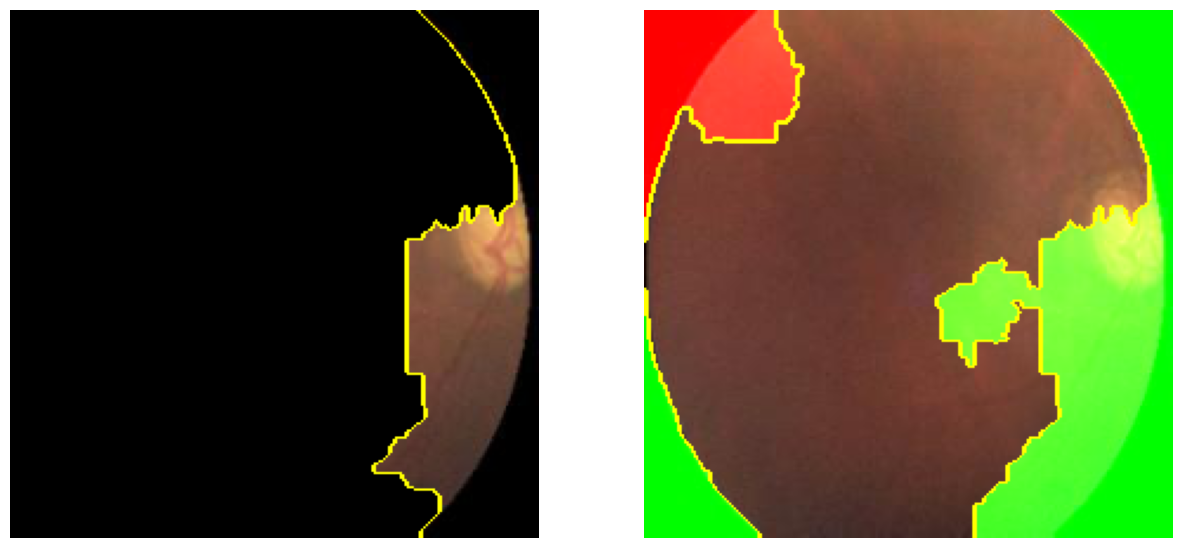

In [22]:
explain_prediction("/home/prostoi/Загрузки/archive/dataset/glaucoma/_28_7296137.jpg")

In [23]:
tf.saved_model.save(model, '/home/prostoi/Загрузки/model')

INFO:tensorflow:Assets written to: /home/prostoi/Загрузки/model/assets


INFO:tensorflow:Assets written to: /home/prostoi/Загрузки/model/assets
